#**스마트폰 센서 데이터 기반 모션 분류**
# 단계3 : 단계별 모델링


## 0.미션4

* 단계별로 나눠서 모델링을 수행하고자 합니다.  
* 단계 구분 예시
    * 단계1 : 정적(0), 동적(1) 행동 분류 모델 생성
    * 단계2 : 세부 동작에 대한 분류모델 생성
        * 단계1 모델에서 0으로 예측 -> 정적 행동 3가지 분류 모델링
        * 단계1 모델에서 1으로 예측 -> 동적 행동 3가지 분류 모델링
* 모델 통합
    * 두 단계 모델을 통합하고, 새로운 데이터에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
* 성능 비교
    * 기본 모델링의 성능과 비교
    * 성능 가이드
        * Accuracy : 0.97 ~ 0.99
* 파이프라인 구성
    * test 데이터를 입력하여, 전처리 및 예측결과가 나오도록 함수 구성

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/project3/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import load_model
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, Input
from keras.backend import clear_session
from keras.optimizers import Adam
from keras.regularizers import l1, l2

In [4]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [5]:
data = pd.read_csv(path + 'data01_train.csv')

In [6]:
data.head(2)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,21,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,LAYING


In [7]:
data.tail(2)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
5879,0.212787,-0.048130,-0.121001,-0.041373,0.052449,-0.585361,-0.100714,0.023353,-0.554707,0.219814,...,-0.053556,0.26088,0.551742,-0.943773,-0.862899,-0.718009,0.292856,0.024920,6,WALKING_UPSTAIRS
5880,0.283815,-0.040658,-0.138018,-0.992662,-0.747190,-0.920248,-0.993410,-0.768055,-0.924587,-0.935871,...,-0.696584,0.10769,0.122242,-0.077226,-0.078091,-0.740244,0.008346,-0.146143,29,SITTING


#### 2) 기본 정보 조회

In [8]:
data.shape

(5881, 563)

In [9]:
data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594,17.381568
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479,8.938316
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143,1.000000
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555,8.000000
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951,19.000000
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932,26.000000
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000,30.000000


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 25.3+ MB


## 2.데이터 전처리

* 세부 요구사항
    - Label 추가 : 1단계 모델을 위한 레이블 추가
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

### (1) 1단계 모델링을 위한 레이블

In [16]:
data['is_dynamic'] = np.where(data['Activity'].isin(['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS']), 1, 0)
data_dynamic = data.loc[data['is_dynamic'] == 1]
data_static = data.loc[data['is_dynamic'] == 0]

In [17]:
data.head(2)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,is_dynamic
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,21,STANDING,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,LAYING,0


In [18]:
data_dynamic.head(2)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,is_dynamic
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,17,WALKING,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,17,WALKING_DOWNSTAIRS,1


In [19]:
data_static.head(2)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,is_dynamic
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,21,STANDING,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,LAYING,0


### (2) x, y 분리

In [20]:
x1 = data.drop(columns=['subject', 'Activity', 'is_dynamic'])
x2_1 = data_dynamic.drop(columns=['subject', 'Activity', 'is_dynamic'])
x2_2 = data_static.drop(columns=['subject', 'Activity', 'is_dynamic'])

y1 = data.loc[:, ['is_dynamic']]
y2_1 = data_dynamic.loc[:, ['Activity']]
y2_2 = data_static.loc[:, ['Activity']]

In [23]:
y2_1['Activity'] = y2_1['Activity'].map({'WALKING': 0, 'WALKING_UPSTAIRS': 1, 'WALKING_DOWNSTAIRS': 2})
y2_2['Activity'] = y2_2['Activity'].map({'LAYING': 0, 'SITTING': 1, 'STANDING': 2})

In [24]:
display(y2_1.head(2))
display(y2_2.head(2))

,Activity
3,0
4,2


,Activity
0,2
1,0


### (3) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [25]:
scaler1 = MinMaxScaler()
x1 = pd.DataFrame(scaler1.fit_transform(x1), columns=x1.columns)

scaler2_1 = MinMaxScaler()
x2_1 = pd.DataFrame(scaler2_1.fit_transform(x2_1), columns=x2_1.columns)

scaler2_2 = MinMaxScaler()
x2_2 = pd.DataFrame(scaler2_2.fit_transform(x2_2), columns=x2_2.columns)

In [26]:
display(x1.head(2))
display(x2_1.head(2))
display(x2_2.head(2))

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.526878,0.401033,0.448319,0.005507,0.019335,0.016125,0.005500,0.018720,0.017175,0.035126,...,0.488133,0.249657,0.093564,0.472577,0.477891,0.654361,0.537449,0.201725,0.900647,0.578396
1,0.511749,0.396653,0.450918,0.005224,0.002718,0.006117,0.004906,0.002821,0.006221,0.031332,...,0.375973,0.376595,0.156521,0.462253,0.694229,0.117569,0.887502,0.680309,0.156150,0.420272


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.579031,0.520909,0.453890,0.279567,0.383094,0.193929,0.271237,0.412964,0.183918,0.387193,...,0.47571,0.468114,0.296594,0.365002,0.806402,0.874258,0.464237,0.403890,0.74175,0.470245
1,0.713890,0.765421,0.904334,0.466860,0.316082,0.163577,0.421783,0.329724,0.184852,0.743023,...,0.41673,0.385769,0.217035,0.471641,0.077366,0.012683,0.053995,0.391662,0.69345,0.507251


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.526878,0.401033,0.448319,0.016280,0.022153,0.023644,0.017036,0.018720,0.022091,0.117028,...,0.488133,0.258738,0.097557,0.484001,0.474853,0.663931,0.537449,0.201285,0.900647,0.578396
1,0.511749,0.396653,0.450918,0.015445,0.003114,0.008969,0.015194,0.002821,0.008002,0.104386,...,0.375973,0.390294,0.163200,0.473070,0.704351,0.111652,0.887502,0.680133,0.156150,0.420272


### (4) 데이터 분할
* train, val 분할

In [27]:
# Model 1 데이터
x1_tr, x1_val, y1_tr, y1_val = train_test_split(x1, y1, test_size=0.2, random_state=1234)

# Model 2_1 데이터
x2_1_tr, x2_1_val, y2_1_tr, y2_1_val = train_test_split(x2_1, y2_1, test_size=0.2, random_state=1234)

# Model 2_2 데이터
x2_2_tr, x2_2_val, y2_2_tr, y2_2_val = train_test_split(x2_2, y2_2, test_size=0.2, random_state=1234)

## 3.단계별 모델링

### (1) 단계1

* 세부 요구사항
    * 적절한 단계로 구분한 후, 1단계를 분류하는 모델 생성
        * 예시 : 정적 행동(Laying, Sitting, Standing)과 동적 행동(동적 : Walking, Walking-Up, Walking-Down)을 구분하는 모델 생성.
    * 몇 가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

#### 1) 모델1

In [30]:
model1_1 = Sequential([
    Input(shape=(x1_tr.shape[1], )),
    Dense(128, activation='relu'),
    # Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [31]:
model1_1.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')
hist1_1 = model1_1.fit(x1_tr, y1_tr, epochs=100, validation_split=0.2, verbose=0).history

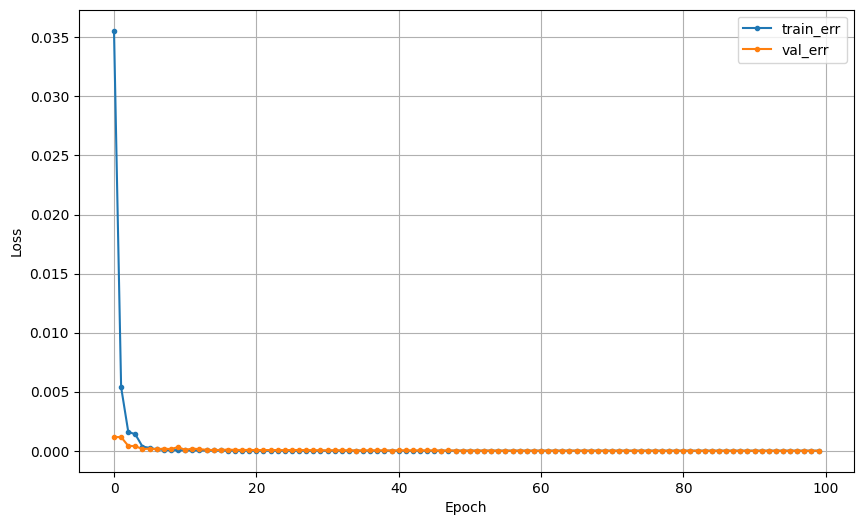

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy score:  1.0
[[639   0]
 [  0 538]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       639
           1       1.00      1.00      1.00       538

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177



In [32]:
dl_history_plot(hist1_1)

pred = model1_1.predict(x1_val)
pred = np.where(pred > 0.5, 1, 0)
print('Accuracy score: ', accuracy_score(y1_val, pred))
print(confusion_matrix(y1_val, pred))
print(classification_report(y1_val, pred))

#### 2) 모델2

In [33]:
model1_2 = Sequential([
    Input(shape=(x1_tr.shape[1], )),
    Dense(1, activation='sigmoid')
])

In [34]:
model1_2.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')
hist1_2 = model1_1.fit(x1_tr, y1_tr, epochs=100, validation_split=0.2, verbose=0).history

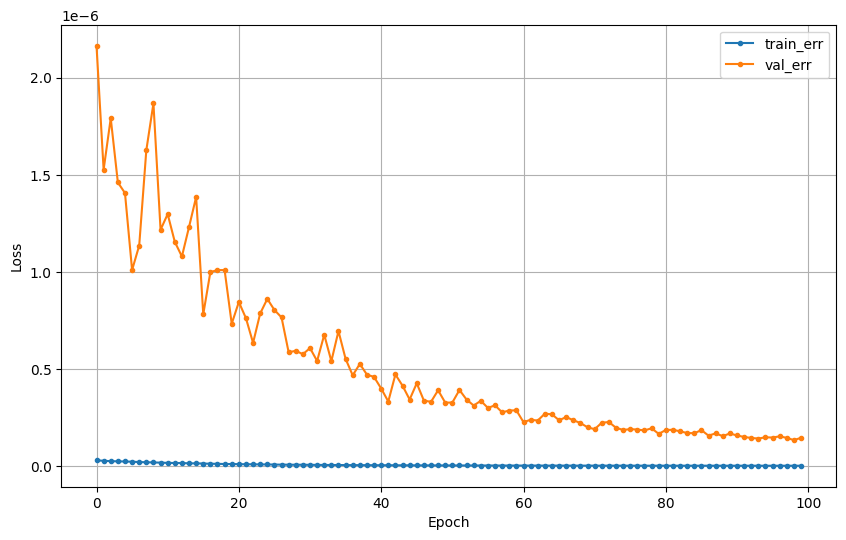

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy score:  0.9473237043330501
[[634   5]
 [ 57 481]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       639
           1       0.99      0.89      0.94       538

    accuracy                           0.95      1177
   macro avg       0.95      0.94      0.95      1177
weighted avg       0.95      0.95      0.95      1177



In [35]:
dl_history_plot(hist1_2)

pred = model1_2.predict(x1_val)
pred = np.where(pred > 0.5, 1, 0)
print('Accuracy score: ', accuracy_score(y1_val, pred))
print(confusion_matrix(y1_val, pred))
print(classification_report(y1_val, pred))

- 더 좋은 성능을 보이는 model1_1 저장

In [37]:
os.makedirs(path + 'weights/', exist_ok=True)
model1_1.save(path + 'weights/model1_best.keras')

### (2) 단계2

#### 1) 단계2-1 : 동적 동작 세부 분류

* 세부 요구사항
    * 동동적 행동(Walking, Walking Upstairs, Walking Downstairs)인 데이터 추출
    * Walking, Walking Upstairs, Walking Downstairs 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [40]:
# 데이터 확인
display(x2_1_tr.head(2))
display(y2_1_tr.head())
print(x2_1_tr.shape)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
1992,0.598360,0.605880,0.549914,0.254016,0.261620,0.249951,0.238222,0.248314,0.253598,0.327776,...,0.619459,0.201250,0.099597,0.334474,0.192899,0.026283,0.625332,0.548315,0.745447,0.641441
83,0.546328,0.568184,0.485541,0.289929,0.278475,0.289998,0.284450,0.292719,0.315348,0.313111,...,0.418643,0.400352,0.219023,0.611113,0.449649,0.972719,0.028394,0.513272,0.840542,0.158921


,Activity
4376,1
169,1
5127,2
1745,2
3666,1


(2117, 561)


In [41]:
model2_1_1 = Sequential([
    Input(shape=(x2_1_tr.shape[1], )),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

In [42]:
model2_1_1.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')
hist2_1_1 = model2_1_1.fit(x2_1_tr, y2_1_tr, epochs=100, validation_split=0.2, verbose=0).history

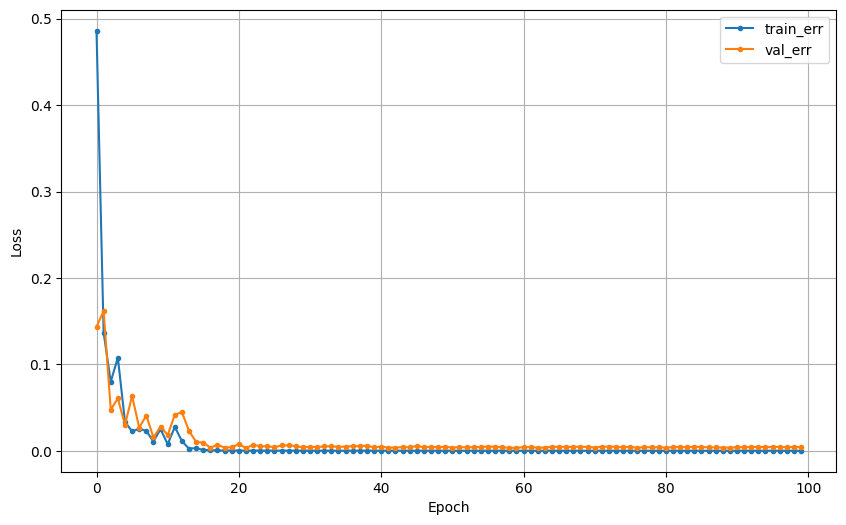

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy score:  1.0
[[212   0   0]
 [  0 166   0]
 [  0   0 152]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       212
           1       1.00      1.00      1.00       166
           2       1.00      1.00      1.00       152

    accuracy                           1.00       530
   macro avg       1.00      1.00      1.00       530
weighted avg       1.00      1.00      1.00       530



In [47]:
dl_history_plot(hist2_1_1)

pred = model2_1_1.predict(x2_1_val)
pred = np.argmax(pred, axis=1)
print('Accuracy score: ', accuracy_score(y2_1_val, pred))
print(confusion_matrix(y2_1_val, pred))
print(classification_report(y2_1_val, pred))

In [48]:
model2_1_1.save(path + 'weights/model2_1_best.keras')

#### 2) 단계2-2 : 정적 동작 세부 분류

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)인 데이터 추출
    * Laying, Sitting, Standing 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [49]:
# 데이터 확인
display(x2_2_tr.head(2))
display(y2_2_tr.head())
print(x2_2_tr.shape)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
953,0.518991,0.396018,0.446704,0.006456,0.005985,0.002180,0.005090,0.005537,0.002368,0.099142,...,0.721267,0.097155,0.027759,0.666826,0.297601,0.742812,0.327897,0.166160,0.824423,0.604829
2316,0.523632,0.404334,0.443419,0.009288,0.039823,0.045266,0.008802,0.036595,0.043839,0.109817,...,0.631336,0.401686,0.251688,0.520419,0.439865,0.569513,0.849527,0.107399,0.841772,0.514224


,Activity
1831,2
4246,2
1995,0
1724,2
2996,0


(2587, 561)


In [68]:
model2_2_1 = Sequential([
    Input(shape = (x2_2_tr.shape[1],)),
    # Dense(512, activation='relu',
    #         kernel_regularizer = l1(0.0001)),
    Dense(256, activation='relu',
            kernel_regularizer = l1(0.0001)),
    Dense(128, activation='relu',
            kernel_regularizer = l1(0.0001)),
    Dense(64, activation='relu',
            kernel_regularizer = l1(0.0001)),
    Dense(32, activation='relu',
            kernel_regularizer = l1(0.0001)),
    Dense( 3, activation = 'softmax')
] )

In [74]:
model2_2_1.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy')
hist2_2_1 = model2_2_1.fit(x2_2_tr, y2_2_tr, epochs=250, validation_split=0.2, verbose=0).history

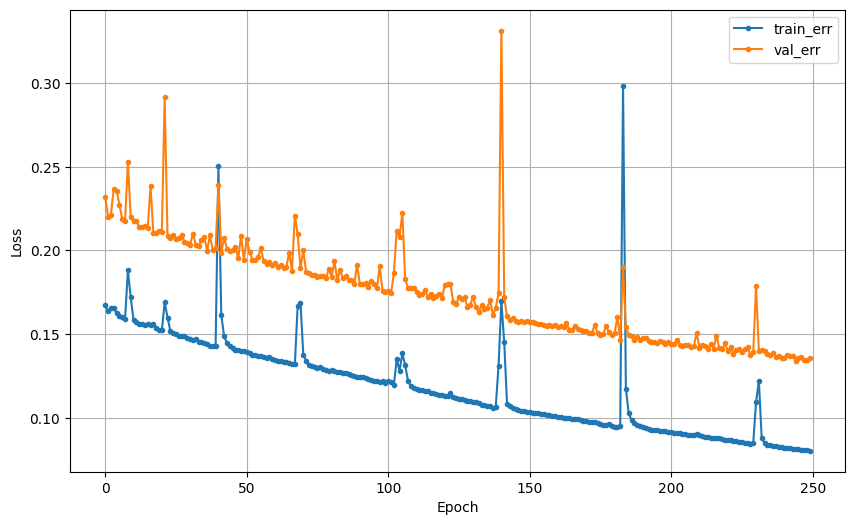

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy score:  0.9845440494590417
[[222   0   0]
 [  0 208   7]
 [  0   3 207]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       222
           1       0.99      0.97      0.98       215
           2       0.97      0.99      0.98       210

    accuracy                           0.98       647
   macro avg       0.98      0.98      0.98       647
weighted avg       0.98      0.98      0.98       647



In [75]:
dl_history_plot(hist2_2_1)

pred = model2_2_1.predict(x2_2_val)
pred = np.argmax(pred, axis=1)
print('Accuracy score: ', accuracy_score(y2_2_val, pred))
print(confusion_matrix(y2_2_val, pred))
print(classification_report(y2_2_val, pred))

In [76]:
model2_2_1.save(path + 'weights/model2_2_best.keras')

In [89]:
joblib.dump(scaler1, path + 'weights/scaler1.pkl')
joblib.dump(scaler2_1, path + 'weights/scaler2_1.pkl')
joblib.dump(scaler2_2, path + 'weights/scaler2_2.pkl')

['/content/drive/MyDrive/project3/weights/scaler2_2.pkl']

In [93]:
model2_2_2 = Sequential([
    Input(shape = (x2_2_tr.shape[1],)),
    Dense(256, activation='relu',
            kernel_regularizer = l1(0.0001)),
    Dense(256, activation='relu',
            kernel_regularizer = l1(0.0001)),
    Dense(128, activation='relu',
            kernel_regularizer = l1(0.0001)),
    Dense(64, activation='relu',
            kernel_regularizer = l1(0.0001)),
    Dense(32, activation='relu',
            kernel_regularizer = l1(0.0001)),
    Dense( 3, activation = 'softmax')
] )

In [94]:
model2_2_2.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy')
hist2_2_2 = model2_2_2.fit(x2_2_tr, y2_2_tr, epochs=200, validation_split=0.2, verbose=0).history

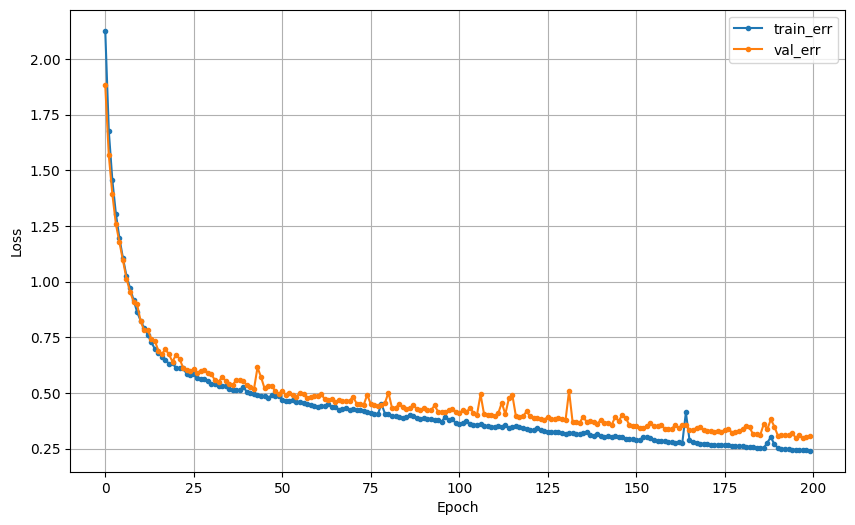

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy score:  0.9860896445131375
[[222   0   0]
 [  0 209   6]
 [  0   3 207]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       222
           1       0.99      0.97      0.98       215
           2       0.97      0.99      0.98       210

    accuracy                           0.99       647
   macro avg       0.99      0.99      0.99       647
weighted avg       0.99      0.99      0.99       647



In [97]:
dl_history_plot(hist2_2_2)

pred = model2_2_2.predict(x2_2_val)
pred = np.argmax(pred, axis=1)
print('Accuracy score: ', accuracy_score(y2_2_val, pred))
print(confusion_matrix(y2_2_val, pred))
print(classification_report(y2_2_val, pred))

In [95]:
# 함수화 과정 전에 성능 평가
# Test data 확인
data_test = pd.read_csv(path + 'data01_test.csv')
data_test.head(2)

data_test1 = scaler1.transform(data_test.drop(columns=['subject', 'Activity']))
is_dynamic_pred = model1_1.predict(data_test1)
is_dynamic_pred = np.where(is_dynamic_pred > 0.5, 1, 0)
data_test['is_dynamic'] = is_dynamic_pred

is_dynamic_real = np.where(data_test['Activity'].isin(['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS']), 1, 0)
print('Accuracy 1-1: ', accuracy_score(is_dynamic_real, is_dynamic_pred))
print(confusion_matrix(is_dynamic_real, is_dynamic_pred))
print(classification_report(is_dynamic_real, is_dynamic_pred))

data_dynamic_test = data_test.loc[data_test['is_dynamic'] == 1]
data_static_test = data_test.loc[data_test['is_dynamic'] == 0]

data_test2_1 = scaler2_1.transform(data_dynamic_test.drop(columns=['subject', 'Activity', 'is_dynamic']))
data_test2_2 = scaler2_2.transform(data_static_test.drop(columns=['subject', 'Activity', 'is_dynamic']))

dynamic_act_pred = model2_1_1.predict(data_test2_1)
static_act_pred = model2_2_1.predict(data_test2_2)

dynamic_act_pred = np.argmax(dynamic_act_pred, axis=1)
static_act_pred = np.argmax(static_act_pred, axis=1)

dynamic_act_real = data_dynamic_test['Activity'].map({'WALKING': 0, 'WALKING_UPSTAIRS': 1, 'WALKING_DOWNSTAIRS': 2})
static_act_real = data_static_test['Activity'].map({'LAYING': 0, 'SITTING': 1, 'STANDING': 2})

print('Accuracy 2-1: ', accuracy_score(dynamic_act_real, dynamic_act_pred))
print('Accuracy 2-2: ', accuracy_score(static_act_real, static_act_pred))
print(confusion_matrix(dynamic_act_real, dynamic_act_pred))
print(confusion_matrix(static_act_real, static_act_pred))
print('Total accuracy: ', (accuracy_score(dynamic_act_real, dynamic_act_pred) * len(dynamic_act_real) + accuracy_score(static_act_real, static_act_pred) * len(static_act_real) ) / len(data_test))

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy 1-1:  1.0
[[833   0]
 [  0 638]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       833
           1       1.00      1.00      1.00       638

    accuracy                           1.00      1471
   macro avg       1.00      1.00      1.00      1471
weighted avg       1.00      1.00      1.00      1471

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy 2-1:  0.9984326018808778
Accuracy 2-2:  0.9771908763505402
[[228   0   0]
 [  1 214   0]
 [  0   0 195]]
[[292   0   0]
 [  1 244   9]
 [  0   9 278]]
Total accuracy:  0.9864038069340585


### (3) 분류 모델 파이프라인 구성


* 세부 요구사항
    * 두 단계 모델을 통합하고, 새로운 데이터(test)에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
    * 데이터 파이프라인 구축 : test데이터가 로딩되어 전처리 과정을 거치고, 예측 및 성능 평가 수행

* 예시
![](https://github.com/DA4BAM/image/blob/main/pipeline%20function.png?raw=true)

#### 1) 함수 만들기

In [106]:
def load_models(path):
    model1 = load_model(path + 'weights/model1_best.keras')
    model2_1 = load_model(path + 'weights/model2_1_best.keras')
    model2_2 = load_model(path + 'weights/model2_2_best.keras')
    return model1, model2_1, model2_2

In [91]:
def pipeline(model_1, model_2, model_3, x_test, path):

    # 데이터 정규화
    scaler1 = joblib.load(path + 'weights/scaler1.pkl')
    scaler2_1 = joblib.load(path + 'weights/scaler2_1.pkl')
    scaler2_2 = joblib.load(path + 'weights/scaler2_2.pkl')

    x_test1 = pd.DataFrame(scaler1.fit_transform(x_test), columns=x_test.columns)

    # 1단계: model_1로 동적(1), 정적(0) 예측
    y_prob_1 = model_1.predict(x_test1)

    y_pred_1 = np.where(y_prob_1 >= 0.5, 1, 0)

    # 동적 데이터의 인덱스 저장
    dynamic_idx = np.where(y_pred_1 == 1)[0]
    static_idx = np.where(y_pred_1 == 0)[0]

    # 2단계: 동적 데이터를 model_2로 예측 (동적인 데이터 필터링)
    x_test2_1 = pd.DataFrame(scaler2_1.transform(x_test), columns=x_test.columns)
    data_dynamic_test = x_test2_1.iloc[dynamic_idx]

    if not data_dynamic_test.empty:  # 동적 데이터가 있을 경우
        y_pred_2 = np.argmax(model_2.predict(data_dynamic_test), axis=1)
        y_pred_2 = np.array(['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'])[y_pred_2]
    else:
        y_pred_2 = np.array([])  # 동적 데이터가 없으면 빈 배열로 처리

    # 3단계: 정적 데이터를 model_3로 예측 (정적인 데이터 필터링)
    x_test2_2 = pd.DataFrame(scaler2_2.transform(x_test), columns=x_test.columns)
    data_static_test = x_test2_2.iloc[static_idx]

    if not data_static_test.empty:  # 정적 데이터가 있을 경우
        y_pred_3 = np.argmax(model_3.predict(data_static_test), axis=1)
        y_pred_3 = np.array(['LAYING', 'SITTING', 'STANDING'])[y_pred_3]
    else:
        y_pred_3 = np.array([])  # 정적 데이터가 없으면 빈 배열로 처리

    # 최종적으로 Activity 예측 결과 병합
    final_predictions = np.empty(x_test.shape[0], dtype=object)
    final_predictions[dynamic_idx] = y_pred_2  # 동적 활동 예측 결과
    final_predictions[static_idx] = y_pred_3  # 정적 활동 예측 결과

    return final_predictions

#### 2) test 셋으로 예측하고 평가하기

In [110]:
# 실제 데이터 형태로 변환
# 실제 데이터는 subject, Activity가 존재하지 않음
# 모델 가중치 및 scaler 값은 이미 보유 중인 것으로 가정
data_test_ = pd.read_csv(path + 'data01_test.csv').drop(columns=['subject', 'Activity'])
model1, model2_1, model2_2 = load_models(path)

results = pipeline(model1, model2_1, model2_2, data_test_, path)
print('Accuracy: ', accuracy_score(data_test['Activity'], results))
print(confusion_matrix(data_test['Activity'], results))
print(classification_report(data_test['Activity'], results))

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy:  0.9864038069340585
[[292   0   0   0   0   0]
 [  1 244   9   0   0   0]
 [  0   9 278   0   0   0]
 [  0   0   0 228   0   0]
 [  0   0   0   0 195   0]
 [  0   0   0   1   0 214]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       292
           SITTING       0.96      0.96      0.96       254
          STANDING       0.97      0.97      0.97       287
           WALKING       1.00      1.00      1.00       228
WALKING_DOWNSTAIRS       1.00      1.00      1.00       195
  WALKING_UPSTAIRS       1.00      1.00      1.00       215

          accuracy                           0.99      1471
         macro avg       0.99      0.99      0.99      1471
      weighted avg       0.99      0.99      0.99      1471

